In [1]:
import importlib
modules = ["maxent", "optimizer", "plot", "solver", "limiirl", "utils"]
def load_modules(modules): 
    for module in modules:
        imported_module = importlib.import_module(module)
        importlib.reload(imported_module)


load_modules(modules)

In [52]:
import pandas as pd 
import numpy as np 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from maxent import irl, irl_causal, feature_expectation_from_trajectories
import optimizer as O 
import solver as S                          # MDP solver (value-iteration)
import plot as P
from sklearn.preprocessing import OneHotEncoder
from limiirl import limiirl, phi, find_policy
from utils import *
from scipy.stats import wasserstein_distance
from process import discretize_S
import os

In [22]:
actions = 5 
discount = 0.9 

In [24]:
def calc_tran_model(taus, states=100, smoothing_value=1): 
    p_transition = np.zeros((states, states, actions)) + smoothing_value

    for traj in taus:
        for tran in traj:

            p_transition[tran[0], tran[2], tran[1]] +=1

        p_transition = p_transition/ p_transition.sum(axis = 1)[:, np.newaxis, :]

    return p_transition

def calc_terminal_states(taus): 
    terminal_states = set() 

    for patient in taus: 
        terminal_states.add(taus[patient][-1])
    
    return list(terminal_states)

def calc_start_dist(taus, S): 
    X = np.zeros(S)
    n = len(taus)

    for tau in taus: 
        X[tau[0]] += 1 

    return X / n 

In [ ]:
def convert_traj(trajectories):
    lst = []
    for patient in trajectories:
        traj = trajectories[patient]
        row = []
        n = len(traj)
        for i in range(0, n-2, 2):
            row.append((traj[i], traj[i+1], traj[i+2]))
        
        lst.append(row)
    
    return lst

In [25]:
def train_single_intent(states):
    """ 
    M: feature representation of vitals 
    """

    trajectories = read_json(f"data/process/trajs_{states}.json")
    trajectories = { int(k) : v for k, v in zip(trajectories.keys(), trajectories.values()) }

    T = convert_traj(trajectories)
    
    state_encoder = OneHotEncoder(sparse=False, categories= [np.arange(states)])

    terminal_states = calc_terminal_states(trajectories)
    p_transition = calc_tran_model(T, states=states)
    features = state_encoder.fit_transform(np.arange(states).reshape(-1, 1))

    
    # set up features: we use one feature vector per state (1 hot encoding for each cluster/state)
    # choose our parameter initialization strategy:
    #   initialize parameters with constant
    init = O.Constant(1.0)

    # choose our optimization strategy:
    #   we select exponentiated stochastic gradient descent with linear learning-rate decay
    optim = O.ExpSga(lr=O.linear_decay(lr0=0.2))

    # actually do some inverse reinforcement learning
    # reward_maxent = maxent_irl(p_transition, features, terminal_states, trajectories, optim, init, eps= 1e-3)

    reward_maxent_causal, theta_causal = irl_causal(p_transition, features, terminal_states, T, optim, init, discount,
                eps=1e-3, eps_svf=1e-4, eps_lap=1e-4)
    
    return reward_maxent_causal, theta_causal

In [26]:
def save_single_intent_results(states): 
    """ 
    states: list of # of states 
    """

    for state in states: 
        reward, theta = train_single_intent(state)
        np.savez(f"data/results/single_intent_{state}", reward=reward, theta=theta)

    return states  

In [27]:
save_single_intent_results([10, 15, 25, 60, 80, 100])

/Users/jaydenpersonnat/MI-IRL/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jaydenpersonnat/MI-IRL/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jaydenpersonnat/MI-IRL/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jaydenpersonnat/MI-IRL/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarn

[10, 15, 25, 60, 80, 100]

In [30]:
reward = []

with np.load('data/results/single_intent_10.npz') as data:
    reward = data['reward']
    print(reward.shape)

(10,)


In [41]:
def plot_reward_heatmap(reward_array):
    """
    Plots a heatmap of the reward at each state.

    Args:
    reward_array (numpy array): 1D numpy array representing the reward for each state.

    The states are indexed from 0 to |S| - 1, where |S| is the length of the reward_array.
    """
    states = np.arange(len(reward_array))
    plt.figure(figsize=(6, 3))
    plt.imshow(reward_array.reshape(1, -1), cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Reward')
    plt.xticks(ticks=states, labels=states)
    plt.yticks([])
    plt.title('State Reward Heatmap')
    plt.xlabel('State')
    plt.ylabel('Reward')
    plt.show()


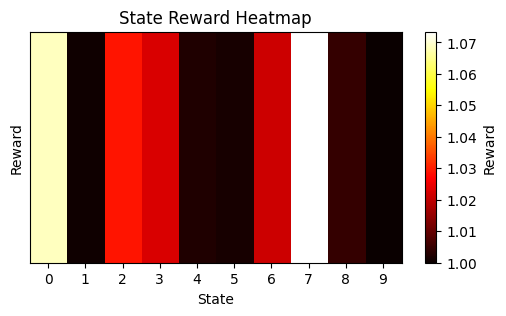

In [42]:
plot_reward_heatmap(reward)

In [46]:
rewards = np.array([reward, reward, reward, reward, reward, reward])

In [47]:
def plot_multiple_reward_heatmaps(reward_matrix):
    """
    Plots separate heatmaps for each reward function in a 2D array.

    Args:
    reward_matrix (numpy array): 2D numpy array where each row represents a reward function.
    
    Each row in the array is considered a separate reward function for a state space,
    and each reward function is plotted as a separate heatmap.
    """
    num_functions = reward_matrix.shape[0]
    num_states = reward_matrix.shape[1]
    states = np.arange(num_states)

    plt.figure(figsize=(15, num_functions * 4))
    
    for i in range(num_functions):
        plt.subplot(num_functions, 1, i + 1)
        plt.imshow(reward_matrix[i].reshape(1, -1), cmap='hot', interpolation='nearest', aspect='auto')
        plt.colorbar(label='Reward')
        plt.xticks(ticks=states, labels=states)
        plt.yticks([])
        plt.title(f'State Reward Heatmap for Function {i+1}')
        plt.xlabel('State')
        plt.ylabel('Reward')

    plt.tight_layout()
    plt.show()


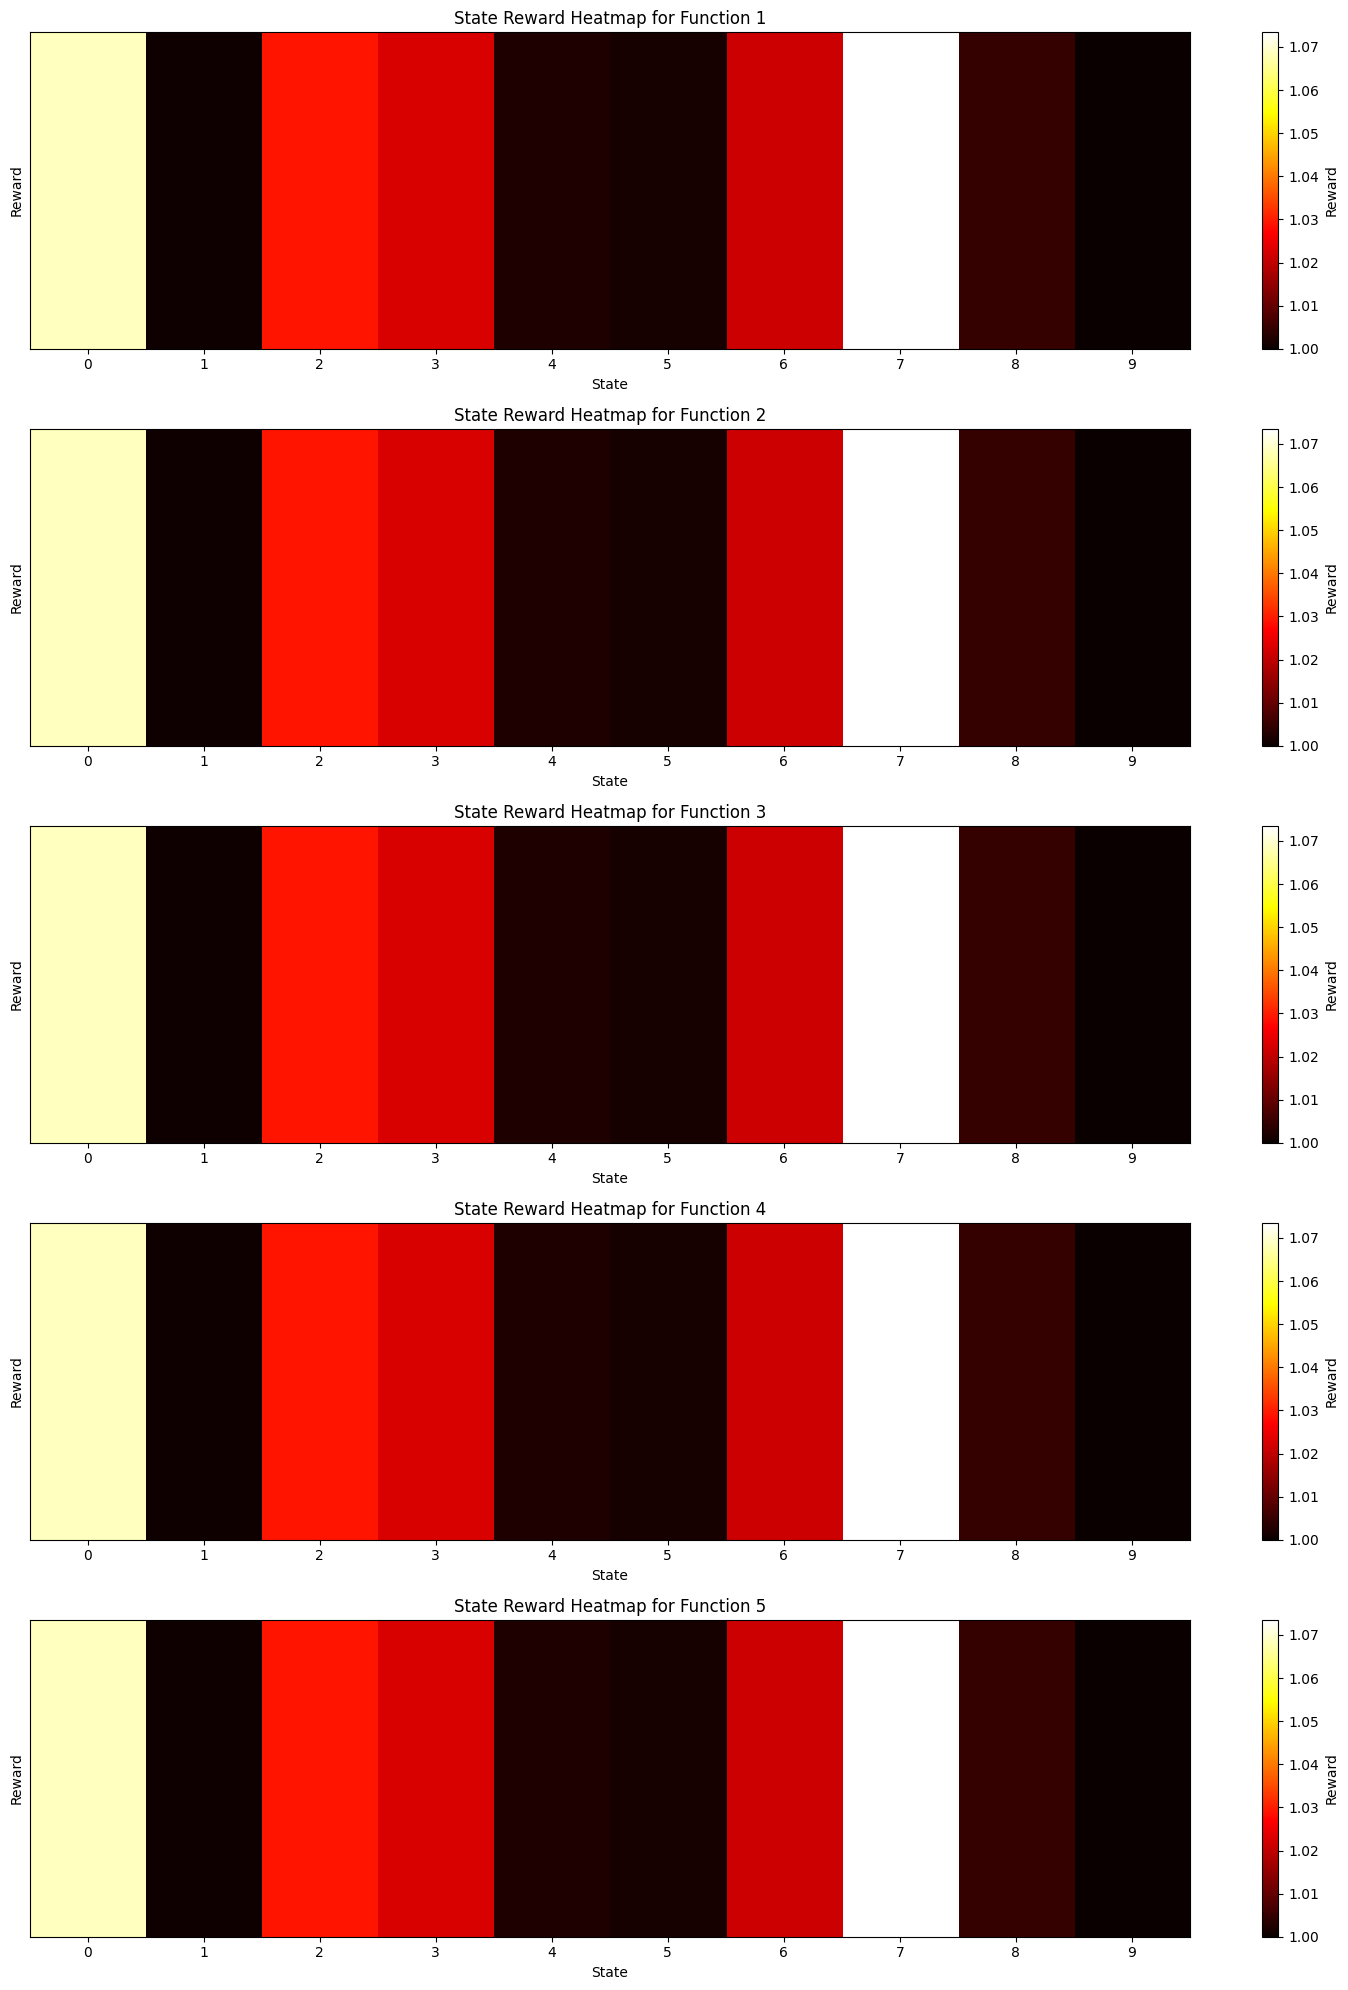

In [48]:
plot_multiple_reward_heatmaps(rewards)

In [97]:
with np.load("data/experiments/trial_1701143809.049189_25.npz") as data:
    print(data['theta'].shape)
    print(data['theta'])

(5, 25)
[[0.98593734 0.99745051 0.99745051 0.93683686 0.99680295 0.99745051
  0.99745051 0.95807863 0.97916224 1.00318946 1.00665113 0.99085999
  0.99745051 0.99745051 0.9786066  0.99745051 0.98966514 0.99451607
  1.00603812 0.99745051 0.99745051 0.99745051 0.99111381 0.7452301
  0.98861599]
 [0.94510597 0.99918948 0.99918948 0.99737991 0.99898811 0.99918948
  0.99918948 0.96797885 0.99605973 0.8434793  1.04150035 0.99712031
  0.99918948 0.99918948 0.99379392 0.99918948 0.99743124 0.99828159
  1.04261776 0.99918948 0.99918948 0.99918948 0.95144396 1.02900728
  0.99665056]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.        ]
 [0.97983564 0.99831488 0.99831488 0.99470875 0.9979109  0.99831488
  0.99831488 0.98285061 0.99268188 0.93651682 0.92415378 0.99397998
  0.99831488 0.99831488 0.98721

In [106]:
def plot_reward_plots(): 
    for root, dirs, files in os.walk("data/experiments"):
        for i, file in enumerate(files): 

            filename = os.path.join(root, file)
            print(filename)
            rewards = [] 
            with np.load(os.path.join(root, file)) as data:
                
                rho = data['rho']
                u = data['u']
                theta = data['theta']

                states = filename.split("_")[2]
                states = int(states.split(".")[0])
                state_encoder = OneHotEncoder(sparse=False, categories= [np.arange(states)])

                features = state_encoder.fit_transform(np.arange(states).reshape(-1, 1))

                single_intent_reward = None 

                with np.load(f"data/results/single_intent_{states}.npz") as d: 
                    single_intent_reward = d['reward']

                
                rewards = [single_intent_reward]
                
                for t in data['theta']:
                    reward_expert = features.dot(t) 
                    rewards.append(reward_expert)

                rewards = np.array(rewards)
                
                plot_multiple_reward_heatmaps(rewards)

            
 


data/experiments/trial_1701641998.780796_80.npz
(3, 80)


/Users/jaydenpersonnat/MI-IRL/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


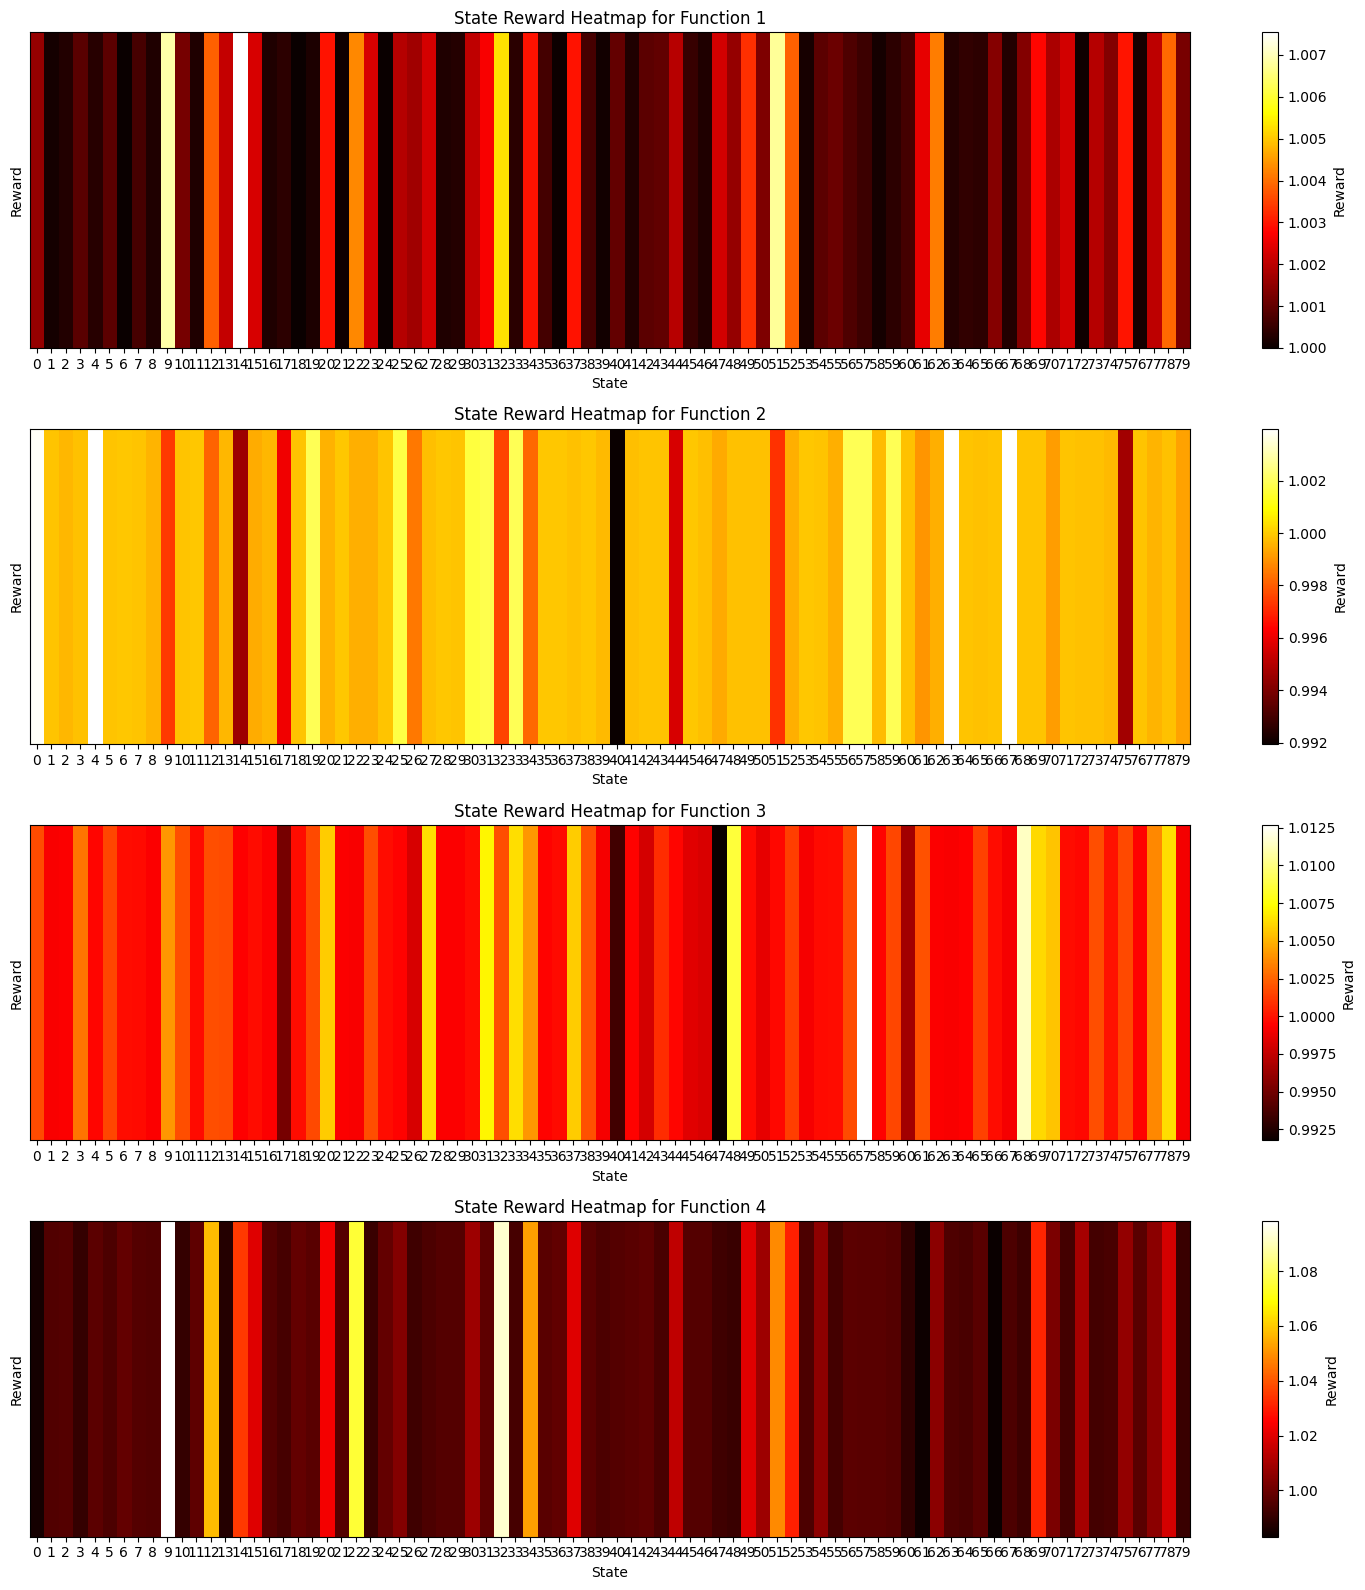

In [108]:
plot_reward_plots()

In [28]:
def plot_reward(dir_name): 
    for root, dirs, files in os.walk(dir_name):
        for file in files: 
            with np.load(os.path.join(root, file)) as data:
                rho = data['rho']
                u = data['u']
                theta = data['theta']

                k = len(rho)

                states = len(theta[0])

                state_encoder = OneHotEncoder(sparse=False, categories= [np.arange(states)])

                features = state_encoder.fit_transform(np.arange(states).reshape(-1, 1))

                
                x = np.arange(states)


                fig, ax = plt.subplots(figsize=(16, 12))

                ax.plot(x, reward_single, label="Single-Intent")

                for i in range(k): 
                    ax.plot(x, features.dot(theta[i]), label=f"Expert {i}")

                ax.legend()
                # Setting the x-axis and y-axis labels
                ax.set_xlabel('state')
                ax.set_ylabel('reward')

                # Setting the x-axis range from 0 to 99
                ax.set_xlim([0, states - 1])

                plt.show()

             

/Users/jaydenpersonnat/MI-IRL/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ValueError: x and y must have same first dimension, but have shapes (100,) and (25,)

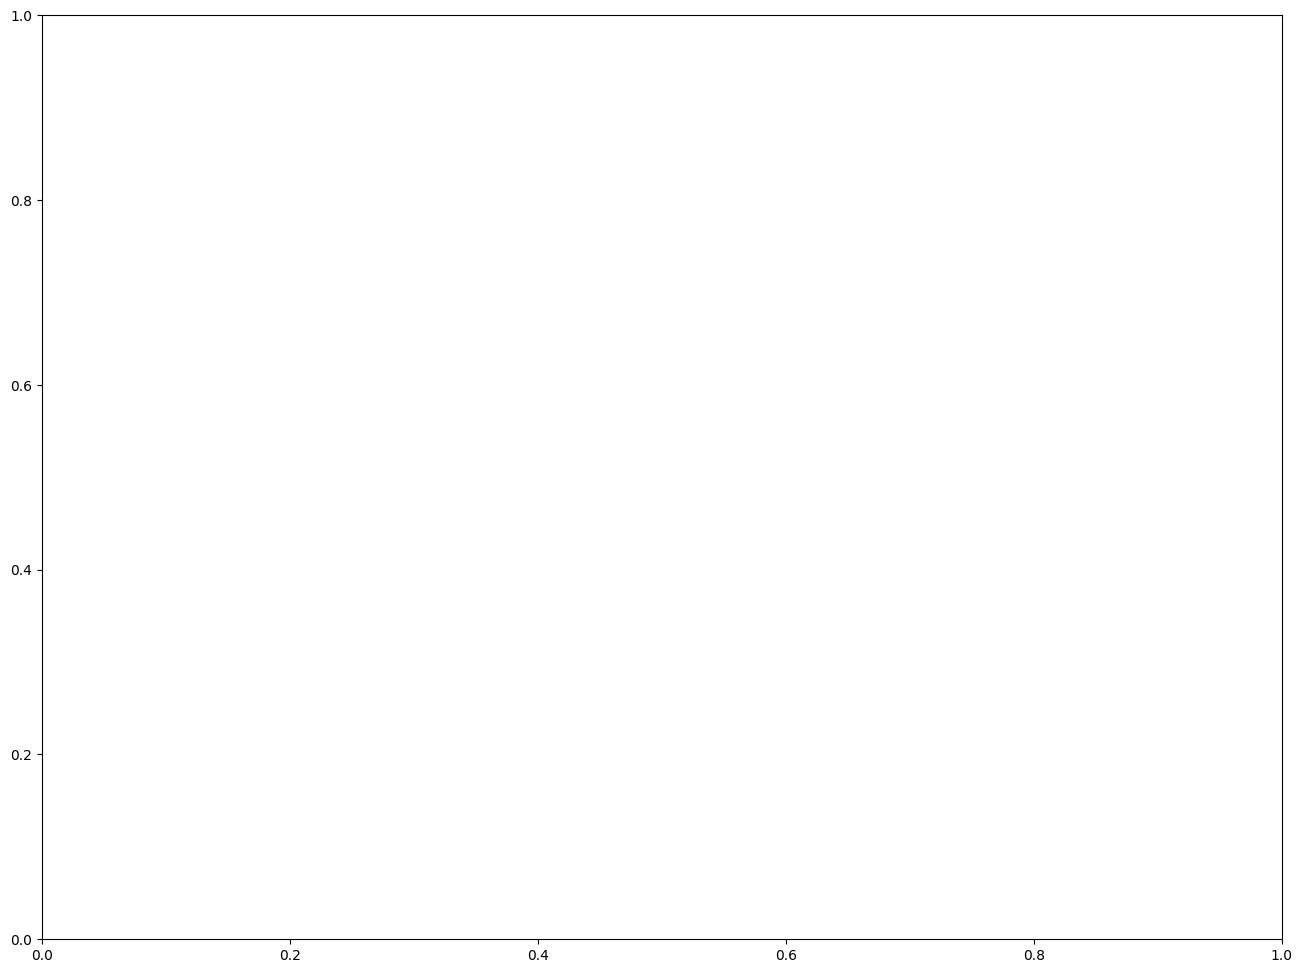

In [29]:
plot_reward("data/experiments/")

In [30]:
def indices_of_top_5(array):
    # Use numpy's argsort to get indices of elements sorted by their values
    # Then take the last 5 indices (which correspond to the highest 5 values)
    return np.argsort(array)[-5:]

In [33]:
with np.load("data/experiments/trial_1701143809.049189.npz") as data: 
    rho = data['rho']
    u = data['u']
    theta = data['theta']

K = len(theta)

print(sorted(np.argsort(reward_single)[-10:]))
for k in range(K): 
    reward = features.dot(theta[k])
    print(sorted(np.argsort(reward)[-10:]))

[0, 3, 7, 8, 9, 10, 14, 18, 22, 23]
[1, 2, 6, 9, 10, 12, 13, 15, 18, 19]
[2, 6, 10, 12, 13, 15, 18, 19, 20, 23]
[1, 2, 3, 4, 5, 6, 7, 8, 11, 24]
[1, 2, 6, 12, 13, 15, 19, 20, 21, 23]
[1, 2, 3, 4, 5, 6, 7, 10, 11, 24]


/Users/jaydenpersonnat/MI-IRL/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(25,)
(25,)
(25,)
(25,)
(25,)


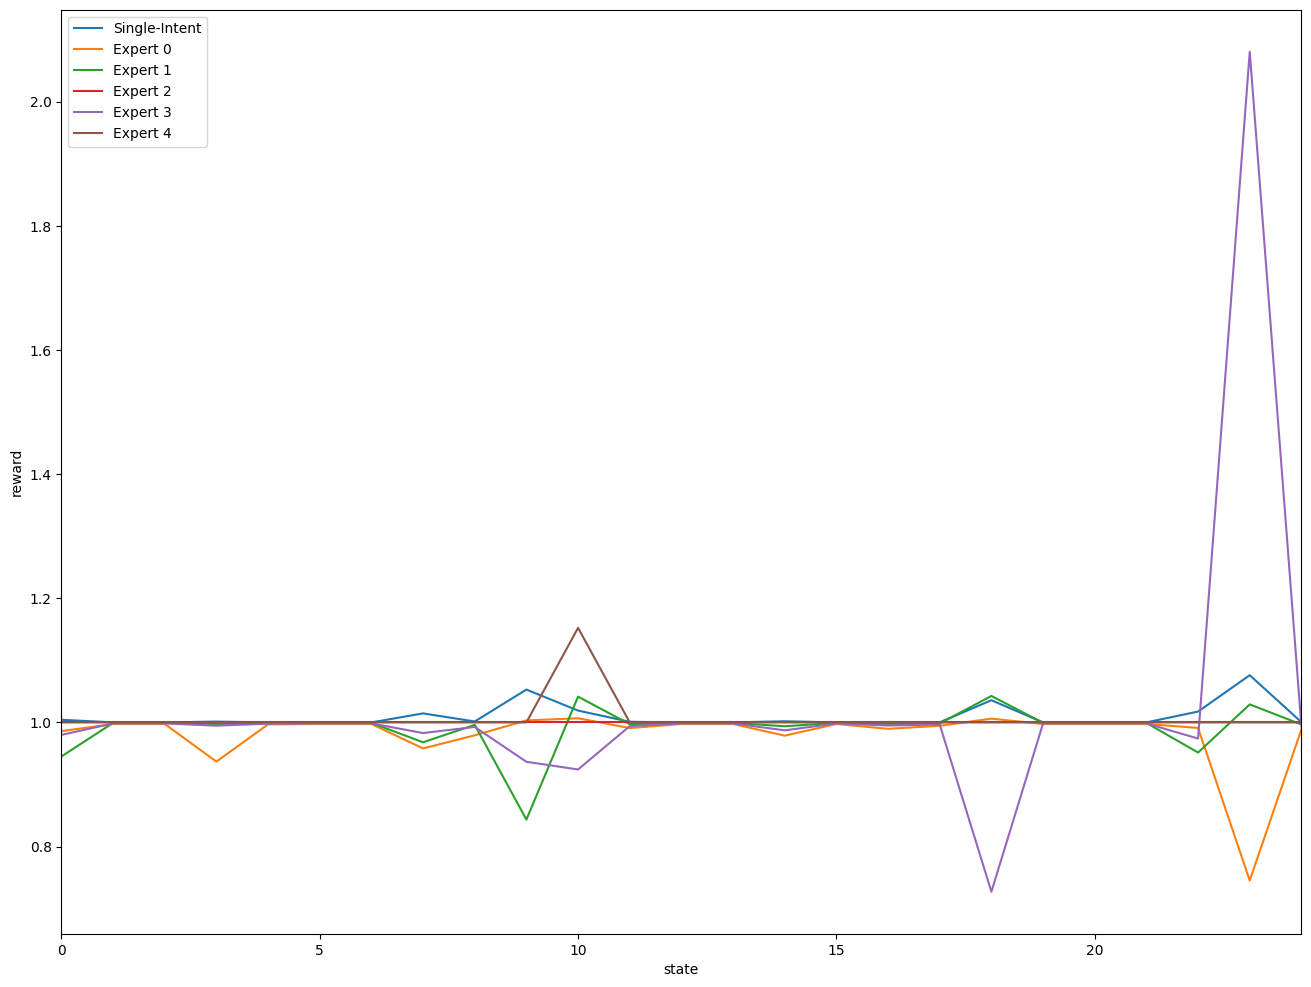

In [34]:
with np.load("data/experiments/trial_1701143809.049189.npz") as data:
    rho = data['rho']
    u = data['u']
    theta = data['theta']

    k = len(rho)
    states = len(theta[0])
    state_encoder = OneHotEncoder(sparse=False, categories= [np.arange(states)])
    features = state_encoder.fit_transform(np.arange(states).reshape(-1, 1))

    x = np.arange(states)


    fig, ax = plt.subplots(figsize=(16, 12))

    ax.plot(x, reward_single, label="Single-Intent")

    for i in range(k): 
        print(features.dot(theta[i]).shape)
        ax.plot(x, features.dot(theta[i]), label=f"Expert {i}")

    ax.legend()
    # Setting the x-axis and y-axis labels
    ax.set_xlabel('state')
    ax.set_ylabel('reward')

    # Setting the x-axis range from 0 to 99
    ax.set_xlim([0, states - 1])

    plt.show()


In [ ]:
feautres

In [35]:
with np.load("data/experiments/trial_1701143809.049189.npz") as data: 
    rho = data['rho']
    u = data['u']
    theta = data['theta']

K = len(theta)

print((np.argsort(reward_single)[-5:]))
for k in range(K): 
    reward = features.dot(theta[k])
    print((np.argsort(reward)[-5:]))

[22 10 18  9 23]
[ 6 12  9 18 10]
[ 6 12 23 10 18]
[ 3  2  1 11 24]
[21  1  6 12 23]
[ 2  1 11 24 10]


In [36]:
patients_df = read_csv_to_dataframe("data/patients.csv")
inputevents_df = read_csv_to_dataframe("data/inputevents.csv")
vitalsign_df = read_csv_to_dataframe("data/vitalsign.csv")

In [37]:
data_pv = pd.merge(patients_df, vitalsign_df, on='subject_id', how='inner')

In [336]:
data_pv

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
0,10000032,F,52,2180,2014 - 2016,2180-09-09,32952584,2180-07-22 16:36:00,98.4,83.0,24.0,97.0,90.0,51.0,Sinus Bradycardia,0
1,10000032,F,52,2180,2014 - 2016,2180-09-09,32952584,2180-07-22 16:43:00,98.4,85.0,22.0,98.0,76.0,39.0,Sinus Bradycardia,0
2,10000032,F,52,2180,2014 - 2016,2180-09-09,32952584,2180-07-22 16:45:00,98.4,84.0,22.0,97.0,75.0,39.0,Sinus Bradycardia,0
3,10000032,F,52,2180,2014 - 2016,2180-09-09,32952584,2180-07-22 17:56:00,98.4,84.0,20.0,99.0,86.0,51.0,Sinus Bradycardia,0
4,10000032,F,52,2180,2014 - 2016,2180-09-09,32952584,2180-07-22 18:37:00,98.4,86.0,20.0,98.0,65.0,37.0,Sinus Bradycardia,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564605,19999828,F,46,2147,2017 - 2019,2164-09-17,32917002,2149-01-08 17:10:00,98.1,109.0,15.0,96.0,111.0,78.0,Sinus Tachycardia,0
1564606,19999914,F,49,2158,2017 - 2019,NaN,32002659,2158-12-24 11:43:00,99.5,81.0,10.0,100.0,93.0,55.0,Sinus Tachycardia,0
1564607,19999987,F,57,2145,2011 - 2013,NaN,34731548,2145-11-02 19:40:00,99.3,112.0,18.0,NaN,118.0,83.0,Sinus Tachycardia,unable
1564608,19999987,F,57,2145,2011 - 2013,NaN,34731548,2145-11-02 20:11:00,99.3,111.0,18.0,NaN,123.0,82.0,Sinus Tachycardia,unable


In [38]:
def calculate_cluster_medians(data, cluster_labels):
    """
    Calculate the average of each feature in each cluster.

    :param data: N x d array of data points (N data points, d features)
    :param cluster_labels: Array of length N with the cluster label for each data point
    :return: K x d array of cluster averages (K clusters, d features)
    """
    unique_clusters = np.unique(cluster_labels)
    num_features = data.shape[1]
    cluster_medians = np.zeros((len(unique_clusters), num_features))

    for i, cluster in enumerate(unique_clusters):
        cluster_data = data[cluster_labels == cluster]
        cluster_medians[i] = np.median(cluster_data, axis=0)

    return cluster_medians

In [39]:
def calculate_cluster_averages(data, cluster_labels):
    """
    Calculate the average of each feature in each cluster.

    :param data: N x d array of data points (N data points, d features)
    :param cluster_labels: Array of length N with the cluster label for each data point
    :return: K x d array of cluster averages (K clusters, d features)
    """
    unique_clusters = np.unique(cluster_labels)
    num_features = data.shape[1]
    cluster_averages = np.zeros((len(unique_clusters), num_features))

    for i, cluster in enumerate(unique_clusters):
        cluster_data = data[cluster_labels == cluster]
        cluster_averages[i] = np.mean(cluster_data, axis=0)

    return cluster_averages

In [40]:
med = calculate_cluster_medians(M, state_model.labels_)

In [41]:
avg = calculate_cluster_averages(M, state_model.labels_)

In [42]:
med

array([[1.0000e+00, 5.7000e+01, 9.8100e+01, 7.9000e+01, 1.8000e+01,
        9.8000e+01, 1.2600e+02, 7.2000e+01, 9.8000e+01],
       [0.0000e+00, 5.8000e+01, 9.7800e+01, 6.4000e+01, 1.8000e+01,
        9.7000e+01, 1.4600e+02, 4.3459e+04, 9.0000e+00],
       [1.0000e+00, 7.9000e+01, 9.8200e+01, 9.1000e+01, 9.4452e+04,
        9.5000e+01, 1.2600e+02, 7.1000e+01, 4.0000e+00],
       [1.0000e+00, 5.6000e+01, 9.8100e+01, 8.0000e+01, 1.8000e+01,
        9.8000e+01, 1.2700e+02, 7.2000e+01, 5.3500e+02],
       [0.0000e+00, 5.4000e+01, 9.8100e+01, 8.8000e+01, 1.8000e+01,
        9.8000e+01, 1.5000e+01, 6.1030e+03, 4.0000e+00],
       [0.0000e+00, 6.4000e+01, 9.8400e+01, 1.0700e+02, 1.8000e+01,
        1.0000e+02, 1.4000e+02, 9.7100e+04, 4.0000e+00],
       [5.0000e-01, 6.5000e+01, 9.8250e+01, 7.5000e+01, 1.5000e+01,
        9.9000e+01, 1.2150e+02, 6.5600e+04, 3.5000e+00],
       [1.0000e+00, 6.3000e+01, 9.8100e+01, 8.3000e+01, 1.8000e+01,
        9.8000e+01, 1.6800e+02, 9.0000e+01, 4.0000e+00],


In [47]:
def create_dataframe_from_matrix(matrix, feature_labels):
    """
    Create a DataFrame from a given matrix and feature labels.

    :param matrix: An N x d numpy array or list of lists, where N is the number of data points and d is the number of features.
    :param feature_labels: A list of labels for the d features.
    :return: A Pandas DataFrame with the given data and feature labels.
    """
    if len(feature_labels) != matrix.shape[1]:
        raise ValueError("The number of feature labels must match the number of columns in the matrix.")

    return pd.DataFrame(matrix, columns=feature_labels)

In [44]:
counts = {} 

for index, label in enumerate(state_model.labels_): 
    if label == 3: 
        print(index)
    if label in counts: 
        counts[label] += 1 
    else: 
        counts[label] = 1 

476311
477486
477487
477767
477768
477769
477770
477771
477772
477773
477774
477775
477776
477777
477778
477779
477780
477781
477782
477783
477784
477785
477786
477787
477788
477789
477790
477791
477792
477793
477794
477795
477796
477797
477798
477799
477800
477801
477802
477803
477804
477805
477806
477807
477808
477809
477810
477811
477812
477813
477814
477815
477816
477817
477818
477819
477820
477821
477822
477823
477824
477825
477826
477827
477828
477829
477830
477831
477832
477833
477834
477835
477836
477837
477838
477839
477840
477841
477842
477843
477844
477845
477846
477847
477848
477849
477850
477851
477852
477853
477854
477855
477856
477857
477858
477859
477860
477861
477862
477863
477864
477865
477866
477867
477868
478727
484743
492873
492874
492875
492876
492877
492878
495172
495173
495174
495175
495176
495177
495178
495179
495180
495181
495182
495183
495184
495185
495186
495187
495188
495189
495190
495191
495192
495193
495194
495195
495196
495197
495198
495199
495200
495201

In [49]:
feature_labels =  ["gender", "anchor_age", "temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp", "rhythm"]

In [51]:
df = create_dataframe_from_matrix(med, feature_labels)

gender             0.0
anchor_age        58.0
temperature       97.8
heartrate         64.0
resprate          18.0
o2sat             97.0
sbp              146.0
dbp            43459.0
rhythm             9.0
Name: 1, dtype: float64

In [54]:
b = create_dataframe_from_matrix(avg, feature_labels)

In [55]:
b

,gender,anchor_age,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm
0,0.529486,55.039123,97.935998,80.920894,17.749463,97.882090,127.954572,72.326347,94.267448
1,0.000000,58.000000,97.800000,64.000000,18.000000,97.000000,146.000000,43459.000000,9.000000
2,1.000000,79.000000,98.200000,91.000000,94452.000000,95.000000,126.000000,71.000000,4.000000
3,0.528515,54.200112,97.771886,81.309132,17.740728,97.916751,128.940168,73.187787,541.486835
4,0.435294,53.235294,98.112941,89.611765,18.435294,97.400000,24.447059,6078.352941,23.164706
5,0.000000,64.000000,98.400000,107.000000,18.000000,100.000000,140.000000,97100.000000,4.000000
6,0.500000,65.000000,98.250000,75.000000,15.000000,99.000000,121.500000,65600.000000,3.500000
7,0.509028,63.097124,98.057262,84.229725,18.146524,97.763915,170.664809,91.169698,6.637342
8,0.485542,54.348457,98.238191,79.884432,17.641710,97.887450,127.496933,72.862526,378.320222
9,0.510031,55.955775,98.158981,111.638951,19.791220,97.267824,120.530641,72.538260,6.686728


In [360]:
counts

{18: 242669,
 15: 125558,
 6: 285101,
 1: 300640,
 13: 243938,
 20: 154309,
 24: 132987,
 11: 707,
 16: 52,
 9: 32944,
 22: 53,
 4: 62,
 19: 12547,
 8: 2,
 2: 2,
 0: 12396,
 17: 3,
 7: 1,
 23: 4,
 12: 11277,
 14: 1,
 3: 1,
 21: 1,
 5: 9354,
 10: 1}

In [383]:
data_pv.iloc[487361]

subject_id                      13135020
gender                                 M
anchor_age                            51
anchor_year                         2177
anchor_year_group            2014 - 2016
dod                           2178-11-21
stay_id                         34589755
charttime            2178-05-01 18:39:00
temperature                         98.6
heartrate                           71.0
resprate                            18.0
o2sat                              100.0
sbp                                 15.0
dbp                              28586.0
rhythm                      Sinus Rhythm
pain                                   2
Name: 487361, dtype: object

In [113]:
def plot_normalized(reward): 
    five_best = np.argsort(reward)[-5:]

    # Reverse the order to get the highest values first
    five_best = five_best[::-1]

    five_worst = np.argsort(reward)[:5][::-1]

    print(five_best)
    print(five_worst)
    z =  np.hstack((five_best, five_worst))

    n = len(feature_labels)
    m = 10 

    M = np.zeros((n, m))

    for feature in range(n): 
        for index, state in enumerate(z): 
            M[feature][index] = b.iloc[state][feature_labels[feature]]

    n, m = M.shape 

    m_transpose = M.T

    for i in range(n): 
        for j in range(m): 
            M[i][j] = M[i][j] / (max(m_transpose[j]) - min(m_transpose[j]))

    print(M)
# Create a 2D grid of random values (replace with your data)

    # Create the heatmap
    plt.imshow(M, cmap='viridis')
    plt.colorbar(label='Relative (normalized) value')

    # Set custom y-axis labels
    plt.yticks(np.arange(len(feature_labels)), feature_labels)

    # Add labels and a title
    plt.xlabel('Clusters')

    plt.title('Critical Features')

    plt.figure(figsize=(16, 12))


    # Show the plot
    plt.show()
    

[18 10 23 12  6]
[14  7 22  0  9]
[[3.95614847e-03 3.38849618e-03 4.94948073e-03 6.88966206e-05
  7.62200931e-06 2.64087999e-03 2.99154236e-03 5.53051793e-03
  4.15526913e-03 4.24952700e-03]
 [5.13846036e-01 2.93415417e-01 6.29288124e-01 6.68251185e-03
  9.90853659e-04 2.66525302e-01 3.69720216e-01 2.81916361e-01
  4.30159780e-01 4.64261597e-01]
 [6.99203025e-01 7.22027452e-01 9.09537106e-01 1.01133272e-02
  1.49771341e-03 4.70622122e-01 5.74570596e-01 8.79614473e-01
  7.65421489e-01 8.14418979e-01]
 [5.12834392e-01 6.08706054e-01 7.03953464e-01 8.71482215e-03
  1.14329268e-03 3.88910435e-01 4.93547571e-01 6.82867948e-01
  6.32439476e-01 9.26261454e-01]
 [1.25079077e-01 1.27201868e-01 1.65887968e-01 1.96341843e-03
  2.28658537e-04 8.57467593e-02 1.06330312e-01 1.51293205e-01
  1.38721413e-01 1.64206528e-01]
 [6.96562140e-01 7.23848158e-01 9.07617213e-01 1.00000001e+00
  1.50914634e-03 4.72698665e-01 5.72851715e-01 8.84050556e-01
  7.65000170e-01 8.07025106e-01]
 [1.00002823e+00 1.00002

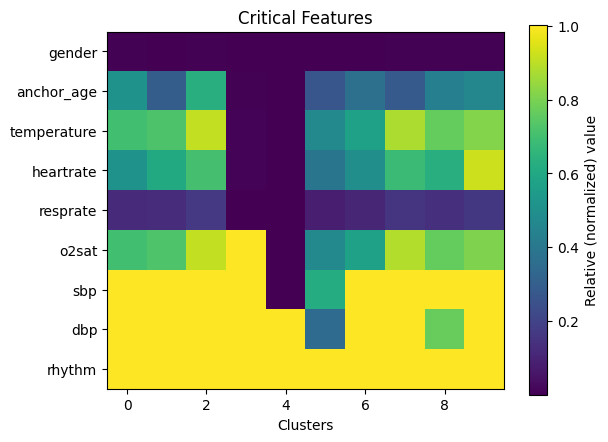

<Figure size 1600x1200 with 0 Axes>

In [114]:
plot_normalized(features.dot(theta[1]))

[23  9 18 10 22]
[ 5 21  2  1 12]


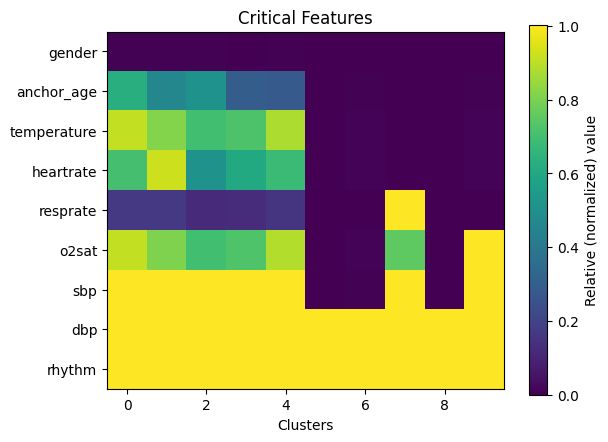

<Figure size 1600x1200 with 0 Axes>

In [89]:
plot_normalized(reward_single)